<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://storage.googleapis.com/dlops-content/public/univailogo.jpeg" height="50px"> <a href='https://welcome.univ.ai/AcceleratedMasters/ai5-c1/' target='_blank'><strong><font color="#324bd9">AI-5: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#324bd9">Lecture 4 - Semantic Segmentation with Transfer Learning</font>**

**Univ.AI**<br/>
**August 2021**<br/>
**Authors/Instructors:**<br/>
Pavlos Protopapas, Shivas Jayaram

<hr style="height:2pt">

## **<font color="#324bd9">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image as Image_Ip

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Sun Aug 22 13:07:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    25W /  75W |    197MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def evaluate_model(model, test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

## **<font color="#324bd9">Semantic Segmentation</font>**

**What is Semantic Segmentation?**

<img src="https://storage.googleapis.com/public_colab_images/ai5/cv_tasks.png" width=80%/>

**Classification:** There is a dog in this image.  
**Semantic Segmentation:** These are all the dog pixels.  
**Object Detection:** There are 5 dogs in this image at these locations. We’re starting to account for objects that overlap.  
**Instance Segmentation:** There are 5 dogs at these locations, and these are the pixels that belong to each one.

### **FCN: Fully-Convolutional Networks**  


[(Paper)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)


Transforming a Classification Network to Segmentation Network:
  
- Changing the fully connected layers into convolution layers enables a classification net to output a heatmap. 
 
     <img src="https://i.imgur.com/WQM9Ksf.png" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>

- Adding layers and a spatial loss (between the output and the segmentation mask) produces an efficient framework for end-to-end dense prediction learning.

- The FCN can be seen as an encoder and decoder network:  
   - Encoder: Spatially downsample the input image to a smaller size (while gaining more channels) through a series of convolutions  
   - Decoder: The encoded output is then upsampled either through bilinear interpolation or a series of transposed convolutions to yield a high-resolution dense prediction. 

    <img src="https://i.imgur.com/VG3N19J.png" alt="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf" width=80%/>
  

### **U-Net: a symetric FCN architecture with skip connections**  

[(Paper)](https://arxiv.org/pdf/1505.04597.pdf)
  - U-Net consists of an almost symetric encoder and decoder. 
  - Most importantly it has skip connections from the output of convolution blocks to the corresponding input of the transposed-convolution block at the same level: these skip connections allow gradients to flow more effectively and provides information from multiple scales of the image.
  
    <img src="https://www.researchgate.net/profile/James_Brown124/publication/328781846/figure/fig1/AS:690171381051392@1541561088555/Diagram-of-the-U-net-architecture-and-two-phase-training-scheme-for-optic-localization.ppm" alt="https://towardsdatascience.com/knowledge-distillation-simplified-dd4973dbc764" width=80%/>

## **<font color="#324bd9">Person Portrait Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/person_potrait_segmentation.zip", 
              base_path="dataset", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.01981727679570516


### **Load Data**

* Read-in data as lists
* Each element in data_x is the path to the image
* Each element in data_y is pixel masks of that image

In [ ]:
label_names = ['background', 'person']
# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Input Images
data_x = glob('dataset/inputs/*.jpg')
print("Dataset count:",len(data_x))
print(data_x[:5])

# Output masks
data_y = [x.replace("inputs","outputs").replace("jpg","png") for x in data_x]
print("Mask files count:",len(data_y))
print(data_y[:6])

Dataset count: 1537
['dataset/inputs/00141.jpg', 'dataset/inputs/02444.jpg', 'dataset/inputs/02362.jpg', 'dataset/inputs/00637.jpg', 'dataset/inputs/00158.jpg']
Mask files count: 1537
['dataset/outputs/00141.png', 'dataset/outputs/02444.png', 'dataset/outputs/02362.png', 'dataset/outputs/00637.png', 'dataset/outputs/00158.png', 'dataset/outputs/02478.png']


### **View Images**

Let's take a look at the data.

In [ ]:
index2label

{0: 'background', 1: 'person'}

['dataset/outputs/00141.png', 'dataset/outputs/02444.png', 'dataset/outputs/02362.png', 'dataset/outputs/00637.png', 'dataset/outputs/00158.png', 'dataset/outputs/02478.png', 'dataset/outputs/02571.png', 'dataset/outputs/02201.png', 'dataset/outputs/02440.png', 'dataset/outputs/00597.png', 'dataset/outputs/00514.png', 'dataset/outputs/00028.png', 'dataset/outputs/02359.png', 'dataset/outputs/02179.png', 'dataset/outputs/00422.png', 'dataset/outputs/00998.png', 'dataset/outputs/02053.png', 'dataset/outputs/02266.png', 'dataset/outputs/00451.png', 'dataset/outputs/00139.png', 'dataset/outputs/00891.png', 'dataset/outputs/02206.png', 'dataset/outputs/00749.png', 'dataset/outputs/00372.png', 'dataset/outputs/02145.png', 'dataset/outputs/02330.png', 'dataset/outputs/00345.png', 'dataset/outputs/02498.png', 'dataset/outputs/02286.png', 'dataset/outputs/01103.png', 'dataset/outputs/01067.png', 'dataset/outputs/00662.png', 'dataset/outputs/00037.png', 'dataset/outputs/00129.png', 'dataset/outp

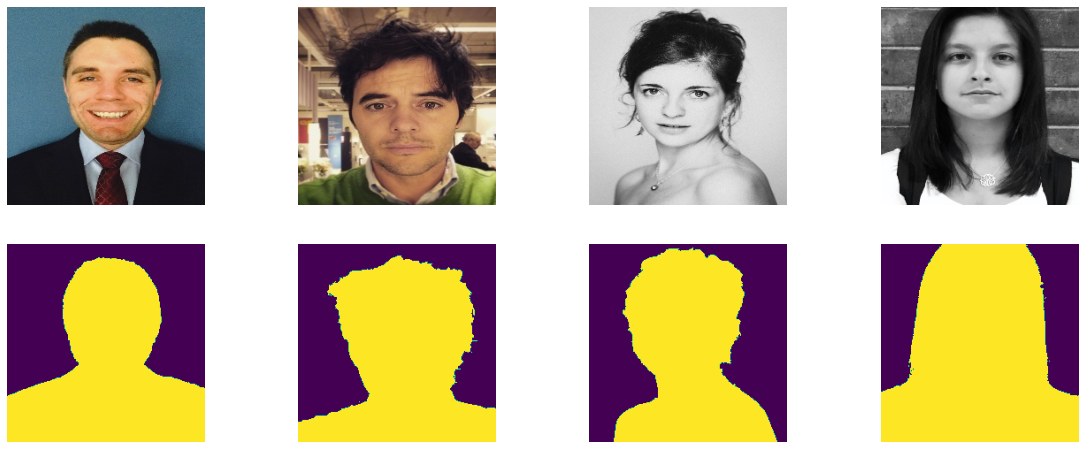

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_x)-1, size=4)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
  axs = fig.add_subplot(2,4,i+1)
  # Read image
  sample_input = cv2.imread(data_x[img_idx])
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  print(data_y)
  sample_mask = cv2.imread(data_y[img_idx])
  sample_mask = sample_mask[:,:,0]
  print("Mask Shape:",sample_mask.shape,"Classes:",np.unique(sample_mask))
  #sample_mask = np.where(sample_mask!=5, 0, sample_mask)
  axs = fig.add_subplot(2,4,i+1+4)
  plt.imshow(sample_mask)
  plt.axis('off')

plt.show()

## **<font color="#324bd9">Build Data Pipelines</font>**

### **Split Data** 
We split data into train, validation

In [ ]:
validation_percent = 0.2

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 1229
validate_x count: 308


### **Create TF Datasets**

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = 2
batch_size = 4
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Load Image
def load_image(input_path, mask_path):
  # Input image
  input_image = tf.io.read_file(input_path)
  input_image = tf.image.decode_jpeg(input_image, channels=num_channels)
  
  # Mask image
  mask_image = tf.io.read_file(mask_path)
  mask_image = tf.image.decode_png(mask_image, channels=1)
  mask_image = tf.cast(mask_image, tf.float32)

  # Random Flipping
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    mask_image = tf.image.flip_left_right(mask_image)
  
  return input_image, mask_image

# Scale pixels
def scale_image_pixels(input_image, mask_image):
  input_image = tf.cast(input_image, tf.float32)
  input_image = input_image/127.5
  input_image -= 1.
  return input_image, mask_image

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, None, None, 3), (None, None, None, 1)), types: (tf.float32, tf.float32)>


## **<font color="#324bd9">Build UNET Model</font>**

In [ ]:
def build_unet_model(image_height, image_width, num_channels, num_output_masks):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = False
          
  conv0 = tranfer_model_base.get_layer("expanded_conv_project").output # 112 x 112
  conv1 = tranfer_model_base.get_layer("block_2_project").output # 56 x 56
  conv2 = tranfer_model_base.get_layer("block_5_project").output # 28 x 28
  conv3 = tranfer_model_base.get_layer("block_12_project").output # 14 x 14
  
  up6 = tranfer_model_base.output 
  conv7 = up6

  up8 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv7), conv3], axis=-1)
  conv8 = keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same',activation='relu',name='conv8_1_3x3')(up8)

  up9 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv8), conv2], axis=-1)
  conv9 = keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)

  up10 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv9), conv1], axis=-1)
  conv10 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv10_1_3x3')(up10)

  up11 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv10), conv0], axis=-1)
  conv11 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv11_1_3x3')(up11)

  up12 = keras.layers.UpSampling2D()(conv11)
  conv12 = keras.layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv12_1_3x3')(up12)

  # Output Layer
  output = keras.layers.Conv2D(filters=num_output_masks,kernel_size=(1, 1), activation="softmax", name="prediction")(conv12)
  #output = layers.Activation("softmax")(output)

  # Build model
  model = Model(inputs=tranfer_model_base.input, outputs=[output], name='unet_mobilenet_'+str(int(time.time())))

  return model

## **<font color="#324bd9">Train</font>**

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/50
308/308 [==============================] - 54s 69ms/step - loss: 0.2397 - accuracy: 0.8991 - val_loss: 0.1724 - val_accuracy: 0.9305
Epoch 2/50
308/308 [==============================] - 20s 64ms/step - loss: 0.1420 - accuracy: 0.9441 - val_loss: 0.1666 - val_accuracy: 0.9372
Epoch 3/50
308/308 [==============================] - 19s 63ms/step - loss: 0.1140 - accuracy: 0.9555 - val_loss: 0.1418 - val_accuracy: 0.9467
Epoch 4/50
308/308 [==============================] - 20s 64ms/step - loss: 0.0991 - accuracy: 0.9621 - val_loss: 0.1242 - val_accuracy: 0.9541
Epoch 5/50
308/308 [==============================] - 19s 63ms/step - loss: 0.0876 - accuracy: 0.9669 - val_loss: 0.1410 - val_accuracy: 0.9505
Epoch 6/50
308/308 [==============================] - 19s 63ms/step - loss: 0.0797 - accuracy: 0.9700 - val_loss: 0.1420 - val_accuracy: 0.9516
Epoch 7/50
308/308 [==============================] - 20s 63ms/step - los

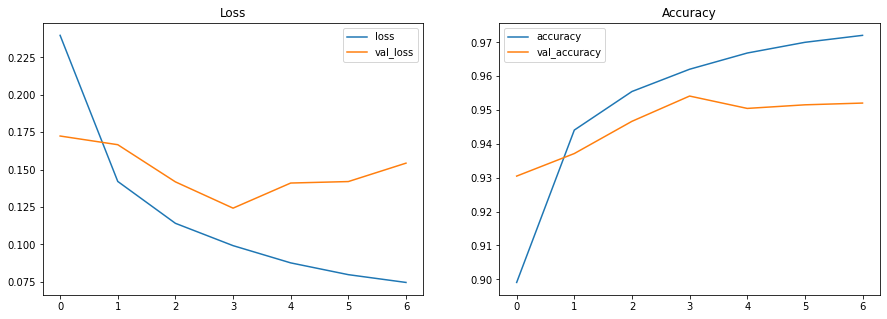

77/77 [==============================] - 3s 33ms/step - loss: 0.1528 - accuracy: 0.9525
Evaluation Results: [0.15284746885299683, 0.9525256752967834]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 50

# Free up memory
K.clear_session()

# Build the model
model = build_unet_model(image_height, image_width, num_channels, num_output_masks)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy()

# Callbacks
# Learning Rate Scheduler: Changes learning rates during training epochs
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.01
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)
callbacks = [lr_scheduler,early_stopping]

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate model
evaluate_model(model,validation_data, training_results)

## **<font color="#324bd9">View Results</font>**

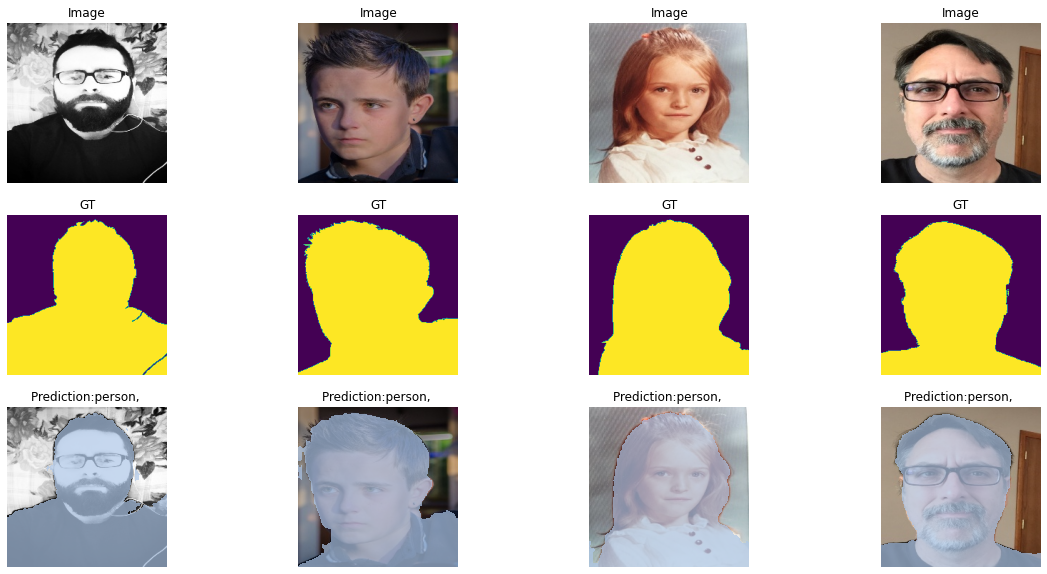

In [ ]:
# Generate a color map
cmap_ref = cm.get_cmap('tab20', 12)
cmap_seg = np.zeros((2, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
cmap_seg[1] = cmap_ref(1)
cmap_seg = ListedColormap(cmap_seg)

def preprocess_prediction(image):

  # crop_x = (image.shape[1] - image_width) // 2
  # crop_y = (image.shape[0] - image_height) // 2
  # image = image[crop_y:crop_y+image_height, crop_x:crop_x+image_width]
  # Scale pixel
  image = image.astype(np.float32)
  image /= 127.5
  image -= 1.

  return image

def preprocess_prediction_image_path(file_path):
  # Read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Reshape
  #image = cv2.resize(image, (image_height, image_width), interpolation=cv2.INTER_AREA)

  return preprocess_prediction(image)

# Generate a random sample of index
image_samples = np.random.randint(0,high=len(validate_x)-1, size=4)

fig = plt.figure(figsize=(20,10))
for i,img_idx in enumerate(image_samples):
  axs = fig.add_subplot(3,4,i+1)
  # Read image
  sample_input = cv2.imread(validate_x[img_idx])
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  axs.set_title("Image")

  sample_mask = cv2.imread(validate_y[img_idx])
  sample_mask = sample_mask[:,:,0]
  axs = fig.add_subplot(3,4,i+1+4)
  plt.imshow(sample_mask)
  plt.axis('off')
  axs.set_title("GT")

  axs = fig.add_subplot(3,4,i+1+8)
  plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  predict_x = [preprocess_prediction_image_path(validate_x[img_idx])]
  predict_x = np.asarray(predict_x)
  # Make predictions
  predictions = model.predict(predict_x)

  sample_pred = predictions[0]
  # Generate mask outputs
  pred_mask = tf.argmax(sample_pred, axis=-1)
  plt.imshow(pred_mask, cmap=cmap_seg, vmin=0, vmax=num_output_masks, alpha=0.7)

  title = "Prediction:"
  for cls in np.unique(pred_mask):
    if cls > 0:
      title = title + index2label[cls] +", "
  axs.set_title(title)

plt.show()

## **<font color="#324bd9">Generate Test Segmentations</font>**

### **Capture Image from Webcam**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


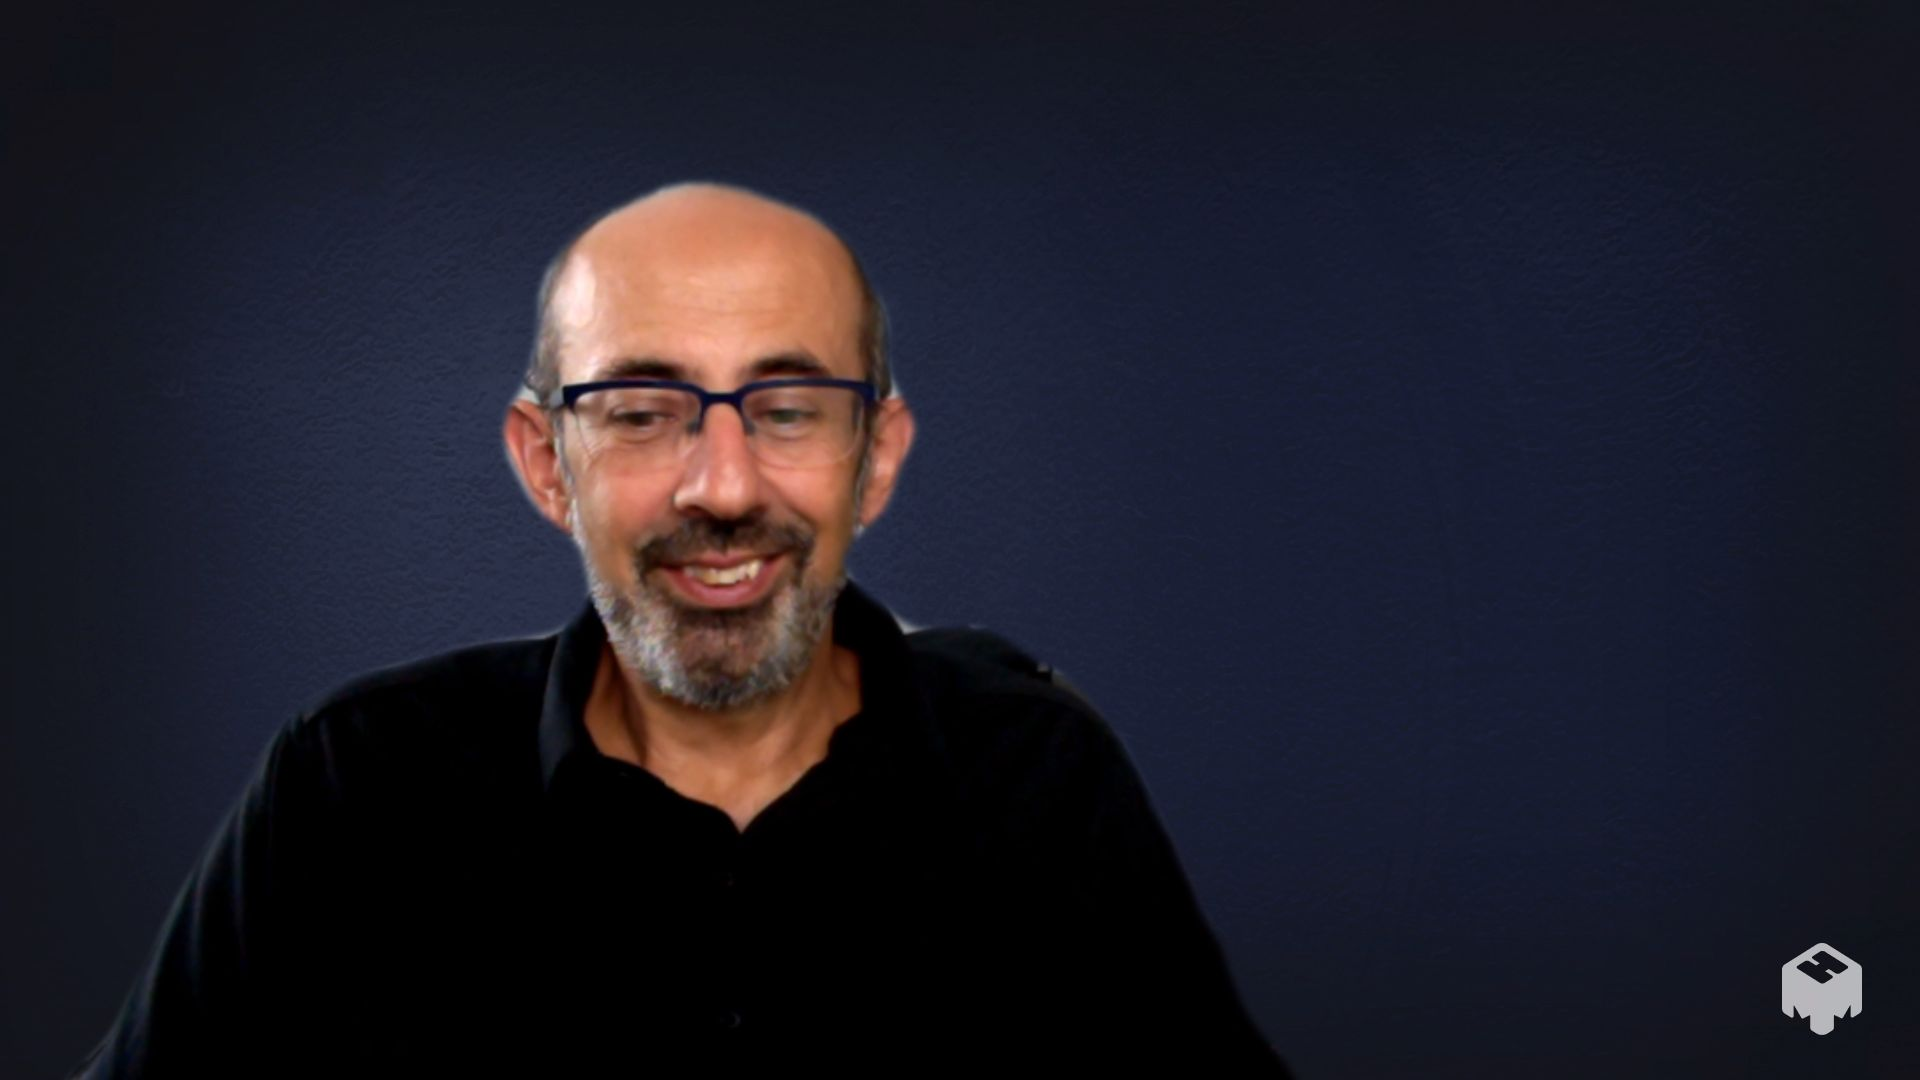

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### **Generate Mask**

Image shape: (224, 224, 3)


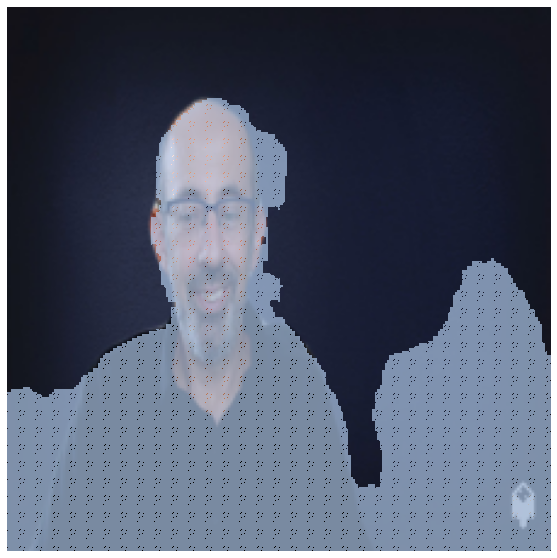

In [ ]:
# Read image
sample_input = cv2.imread(filename)

# Resize image
sample_input = cv2.resize(sample_input, (image_width,image_height), interpolation = cv2.INTER_AREA)
print("Image shape:",sample_input.shape)

# Display image
fig = plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB))
plt.axis('off')

predict_x = [preprocess_prediction(sample_input)]
predict_x = np.asarray(predict_x)
# Make predictions
predictions = model.predict(predict_x)

sample_pred = predictions[0]
# Generate mask outputs
pred_mask = tf.argmax(sample_pred, axis=-1)
plt.imshow(pred_mask, cmap=cmap_seg, vmin=0, vmax=num_output_masks, alpha=0.7)

plt.show()